In [3]:
from colorsys import hls_to_rgb

import numpy as np
import matplotlib.pyplot as plt

from pyzeal.rootfinders.rootfinder import RootFinder
from pyzeal.pyzeal_types.algorithm_types import AlgorithmTypes
from pyzeal.pyzeal_types.estimator_types import EstimatorTypes
from pyzeal.settings.json_settings_service import JSONSettingsService

from pyzeta.core.pyzeta_types.function_systems import FunctionSystemType
from pyzeta.core.pyzeta_types.map_systems import MapSystemType

from pyzeta.framework.initialization.initialization_handler import (
    PyZetaInitializationHandler,
)
from pyzeta.core.zetas.selberg_zeta import SelbergZeta
from pyzeta.core.pyzeta_types.integrals import OrbitIntegralType
from pyzeta.core.zetas.wzeta import WeightedZeta
from pyzeta.core.distributions.ruelle_distribution import RuelleDistribution

PyZetaInitializationHandler.initPyZetaServices()
# deactivate PyZEAL progress bar
JSONSettingsService().verbose = False

In [4]:
import pyzeta.geometry.geodesic
print(pyzeta.geometry.geodesic.__file__)

import pyzeta.geometry.sl2r
print(pyzeta.geometry.sl2r.__file__)

import pyzeta.geometry.visuals
print(pyzeta.geometry.visuals.__file__)

import pyzeta.geometry.helpers
print(pyzeta.geometry.helpers.__file__)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyzeta/geometry/geodesic.py
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyzeta/geometry/sl2r.py
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyzeta/geometry/visuals.py
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyzeta/geometry/helpers.py


resonance=(-1+1.256j) --> order=2
resonance=(-1-0j) --> order=2
resonance=(-1+0.628j) --> order=2
resonance=(-1+1.885j) --> order=2
resonance=(-1+1.256j) --> order=2
resonance=(-1-0j) --> order=2
resonance=(-1+0.628j) --> order=2
resonance=(-1+1.885j) --> order=2


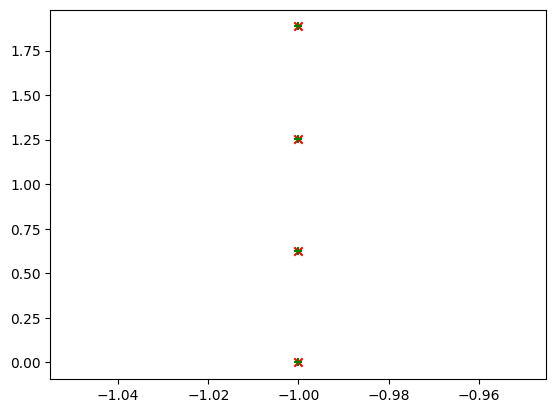

In [3]:
# calculate classical resonances for Schottky and flow adapted cylinders
initArgs = {"funnelWidth": 10.0}
width = initArgs["funnelWidth"]
nMax = 10

for systemType, color, marker in zip(
    [
        MapSystemType.HYPERBOLIC_CYLINDER,
        MapSystemType.FLOW_CYLINDER,
    ],
    ["red", "green"],
    ["x", "+"],
):
    wzeta = WeightedZeta(
        mapSystem=systemType,
        systemInitArgs=initArgs,
        integralType=OrbitIntegralType.CONSTANT,
        integralInitArgs={},
    )

    finder = RootFinder(
        f=lambda s: wzeta(s, nMax=nMax),
        algorithmType=AlgorithmTypes.SIMPLE_ARGUMENT,
        estimatorType=EstimatorTypes.SUMMATION_ESTIMATOR,
    )

    finder.calculateRoots(
        reRan=(-1.4, -0.5), imRan=(-0.1, 2.2), precision=(3, 2)
    )
    for res, order in zip(finder.roots, finder.orders):
        print(f"resonance={res} --> order={order}")

    plt.scatter(finder.roots.real, finder.roots.imag, c=color, marker=marker)

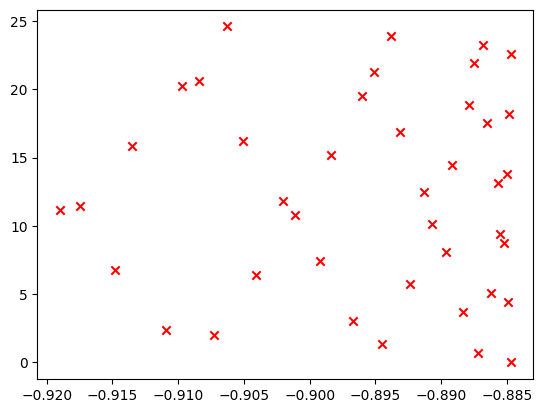

In [4]:
# calculate classical resonances for non-geometric torus coordinate choice
initArgs = {"outerLen": 10.0, "innerLen": 10.0, "angle": np.pi / 2.0}
nMax = 6

systemType = MapSystemType.FUNNEL_TORUS
color = "red"
marker = "x"

zeta = WeightedZeta(
    mapSystem=systemType,
    systemInitArgs=initArgs,
    integralType=OrbitIntegralType.CONSTANT,
    integralInitArgs={},
)

finder = RootFinder(
    f=lambda s: zeta(s, nMax=nMax),
    algorithmType=AlgorithmTypes.SIMPLE_ARGUMENT,
    estimatorType=EstimatorTypes.SUMMATION_ESTIMATOR,
)

finder.calculateRoots(
    reRan=(-0.92, -0.88), imRan=(-0.0, 25.0), precision=(3, 2)
)

plt.scatter(finder.roots.real, finder.roots.imag, c=color, marker=marker)

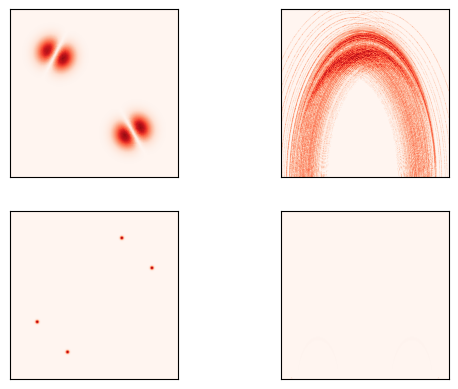

In [5]:
# calculate Ruelle dist at delta-1 for Schottky and flow-adapted systems
from typing import Final, List, Optional, Tuple, Type
FIRST_RESONANCE: Final[complex] = -1.0 + 0.0j

_, axs = plt.subplots(2, 2)

for i, integralType in enumerate(
    [OrbitIntegralType.POINCARE, OrbitIntegralType.FUNDAMENTAL_DOMAIN]
):
    for j, systemType in enumerate(
        [MapSystemType.HYPERBOLIC_CYLINDER, MapSystemType.FLOW_CYLINDER]
    ):
        ruelle = RuelleDistribution(
            systemType,
            systemInitArgs={"funnelWidth": 5.0},
            integralType=integralType,
            sigma=5e-2,
            numSupportPts=600,
        )

        firstDistribution = ruelle(
            np.array([FIRST_RESONANCE], dtype=np.complex128), nMax=7
        )[0]
        axs[j][i].imshow(
            np.abs(firstDistribution), cmap="Reds", origin="lower"
        )
        axs[j][i].set_xticks([])
        axs[j][i].set_yticks([])

plt.show()

In [6]:
# calculate Ruelle distribution beyond delta-1 for conventional torus params
HIGHER_RESONANCE: Final[complex] = -0.8847
systemType = MapSystemType.FUNNEL_TORUS
systemInitArgs = {"outerLen": 10.0, "innerLen": 10.0, "angle": np.pi / 2.00}
N_MAX = 7

poincareArgs = {
    "sigma": 1e-3,
    "refinementLevel": 0,
    "minusIndices": [1, 2, 3],
    "plusIndices": [0, 1],
}
fundamentalDomainArgs = {
    "sigma": 6e-2,
    "refinementLevel": 0,
}

_, (axs1, axs2) = plt.subplots(2, 4)

for i, axs in enumerate((axs1, axs2)):
    for j, (integralType, args) in enumerate(
        zip(
            [OrbitIntegralType.POINCARE, OrbitIntegralType.FUNDAMENTAL_DOMAIN],
            [poincareArgs, fundamentalDomainArgs],
        )
    ):
        ruelle = RuelleDistribution(
            systemType,
            systemInitArgs=systemInitArgs,
            integralType=integralType,
            numSupportPts=300,
            **args,
        )

        higherDistribution = ruelle(
            np.array([HIGHER_RESONANCE], dtype=np.complex128), nMax=N_MAX + i
        )[0]

        # create a phase-lightness representation of the distribution
        absoluteValue = np.abs(higherDistribution)
        argument = np.angle(higherDistribution)
        hue = (argument + np.pi) / (2 * np.pi) + 0.5
        lightness = 1.0 - 1.0 / (1.0 + absoluteValue**0.2)
        saturation = 0.8

        rgb = np.array(np.vectorize(hls_to_rgb)(hue, lightness, saturation))
        rgb = rgb.swapaxes(0, 2).swapaxes(0, 1)

        axs[2 * j].imshow(np.abs(1.0 - rgb), cmap="Reds", origin="lower")
        axs[2 * j].set_xticks([])
        axs[2 * j].set_yticks([])

        axs[2 * j + 1].imshow(
            np.abs(higherDistribution), cmap="Reds", origin="lower"
        )
        axs[2 * j + 1].set_xticks([])
        axs[2 * j + 1].set_yticks([])

plt.show()

: 

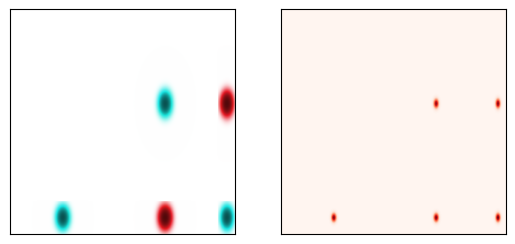

In [5]:
# calculate Ruelle distribution beyond delta-1 for conventional torus params
from typing import Final, List, Optional, Tuple, Type

HIGHER_RESONANCE: Final[complex] = -0.9998 + 9.12j
systemType = MapSystemType.FUNNEL_TORUS
systemInitArgs = {"outerLen": 10.0, "innerLen": 10.0, "angle": np.pi / 2.00}
integralType = OrbitIntegralType.POINCARE
N_MAX = 6

poincareArgs = {
    "sigma": 2e-3,
    "refinementLevel": 0,
    "minusIndices": [1, 2, 3],
    "plusIndices": [0, 1],
}

_, (axs1, axs2) = plt.subplots(1, 2)

ruelle = RuelleDistribution(
    systemType,
    systemInitArgs=systemInitArgs,
    integralType=integralType,
    numSupportPts=300,
    **poincareArgs,
)

higherDistribution = ruelle(
    np.array([HIGHER_RESONANCE], dtype=np.complex128), nMax=N_MAX
)[0]

# create a phase-lightness representation of the distribution
absoluteValue = np.abs(higherDistribution)
argument = np.angle(higherDistribution)
hue = (argument + np.pi) / (2 * np.pi) + 0.5
lightness = 1.0 - 1.0 / (1.0 + absoluteValue**0.2)
saturation = 0.8

rgb = np.array(np.vectorize(hls_to_rgb)(hue, lightness, saturation))
rgb = rgb.swapaxes(0, 2).swapaxes(0, 1)

axs1.imshow(np.abs(1.0 - rgb), cmap="Reds", origin="lower")
axs1.set_xticks([])
axs1.set_yticks([])

axs2.imshow(np.abs(higherDistribution), cmap="Reds", origin="lower")
axs2.set_xticks([])
axs2.set_yticks([])

plt.show()